In [1]:
import rebound
print(rebound.__build__)
import numpy as np
import matplotlib.pyplot as plt

Jan  6 2022 19:24:39


Implementation in C for speed:

In [2]:
%%writefile rhs.c
#include "rebound.h"
void derivatives(struct reb_ode* const ode, double* const yDot, const double* const y, const double t){
    struct reb_orbit o = reb_tools_particle_to_orbit(ode->r->G, ode->r->particles[1], ode->r->particles[0]);
    
    // Danby 1962, Goldreich and Peale 1966, Wisdom and Peale 1983
    double omega2 = 3.*0.26; 
    yDot[0] = y[1];
    yDot[1] = -omega2/(2.*o.d*o.d*o.d)*sin(2.*(y[0]-o.f));
}


Overwriting rhs.c


Compiling into a shared library

In [3]:
!cp ../src/librebound.so .
!cp ../src/rebound.h .
!gcc -c -O3 -fPIC rhs.c -o rhs.o
!gcc -L. -shared rhs.o -o rhs.so -lrebound 

Loading the shared library

In [6]:
from ctypes import cdll
clibrhs = cdll.LoadLibrary("rhs.so")

Setting up N-body simulation and ODE

In [101]:
def setup():
    sim = rebound.Simulation()
    sim.add(m=1) # Saturn
    sim.add(a=1, e=0.123233) # Hyperion, massless, semi-major axis of 1
    sim.integrator = "BS"
    sim.ri_bs.eps_rel = 1e-12
    sim.ri_bs.eps_abs = 1e-12
    
    ode_spin = sim.create_ode(length=2, needs_nbody=True)
    ode_spin.y[0] = 0.01  # somewhat arbitrary initial conditions that lead to chaos
    ode_spin.y[1] = 1
    ode_spin.derivatives = clibrhs.derivatives
    
    return sim, ode_spin

Creating two simulations, including one slightly offset to measure the divergence

In [129]:
sim, ode_spin = setup()
sim2, ode_spin2 = setup()
ode_spin2.y[0] += 1e-8 # small perturbation

times = 2.*np.pi*np.logspace(-1,1.5,100) # a couple of orbits
obliq = np.zeros((len(times)))
obliq2 = obliq.copy()

for i, t in enumerate(times):
    sim.integrate(t, exact_finish_time=1)
    sim2.integrate(t, exact_finish_time=1)        
    obliq[i] = ode_spin.y[0]
    obliq2[i] = ode_spin2.y[0]

The Lyapunov timescale is approximately 1.2 orbits. About 25 days! (Wikipedia says ~30 days)

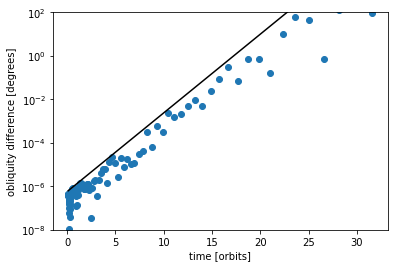

In [130]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [orbits]")
ax.set_ylabel("obliquity difference [degrees]")
ax.set_yscale("log")
ax.set_ylim([1e-8,1e2])
o1 = np.remainder(obliq*180/np.pi,360.)
o2 = np.remainder(obliq2*180/np.pi,360.)
ax.scatter(times/np.pi/2.,np.abs((o1-o2)))
ax.plot(times/np.pi/2.,1e-8/np.pi*180.*np.exp(times/(np.pi*2.)/1.2),color="black");